In [232]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.integrate import ode
from scipy.signal import butter, sosfiltfilt

In [233]:
# ==========================================
# CIRCUIT PARAMETERS
# ==========================================
N = 20                          # Number of resonator fock states

# Circuit parameters
wr = 7.062e9 * 2 * np.pi          # Resonator frequency (7.062 GHz)[from reference]
wq = 5.092e9 * 2 * np.pi          # Qubit frequency (5.092 GHz)[from reference]
w_if = 0.05e9 * 2 * np.pi         # Intermediate frequency used for AWG (50 MHz) [self-defined, not from reference]
w_lo = wr - w_if                  # Local Oscillator frequency (close to resonator freq)
delta = abs(wr - wq)              # Detuning between qubit and resonator (1.97 GHz)[from reference]
k = 0.00535e9 * 2 * np.pi         # Resonator decay rate (5.35 MHz)[from reference]
g = 0.1029e9 * 2 * np.pi          # Coupling strength (102.9 MHz)[from reference]
gamma_1 = 0.001e9 * 2 * np.pi     # Qubit decay (0.1 MHz) [self-defined, not from reference]
gamma_2 = 0.001e9 * 2 * np.pi     # Qubit dephase (0.1 MHz) [self-defined, not from reference]
phi = 0.0 * np.pi                   # AWG phase (set to zero by default)
alpha = 0.157e9 * 2 * np.pi       # Anharmonity (157 MHz) [Chosen to align results]
K = alpha * (g/delta)**4          # Kerr self-nonlinearity (8.18 KHz) [Derived from Yvonne reference]
chi = 2 * alpha * (g/delta)**2    # Dispersive shift, cross non-linearity (5.382 MHz) [Derived from Yvonne reference]

duration = 800e-9
dt = 1e-10
tlist = np.arange(0, duration, dt)  # Time from 0 to 800 ns

### AWG Generation of I/Q components for input into IQ mixer

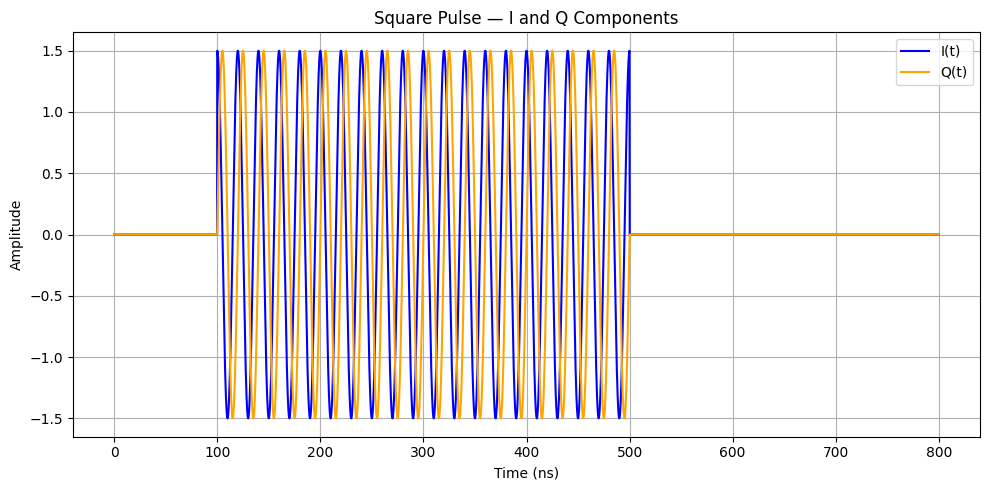

In [234]:
# ==========================================
# BASEBAND SQUARE PULSE
# ==========================================
def b_in(t):
    try:
        pulse_start = 100e-9
        pulse_width = 400e-9
        amp = 1.5
        mask = (t >= pulse_start) & (t < pulse_start + pulse_width)
        envelope = amp * np.exp(1j * (w_if * t + phi)) if mask else 0.0+0.0j
        return envelope
    
    except Exception as e:
        print(f"b_in error at t={t}: {e}")
        return 0.0
    
envelope = np.array([b_in(t) for t in tlist.flatten()])

# I and Q components
I_t = np.real(envelope)
Q_t = np.imag(envelope)


plt.figure(figsize=(10, 5))

plt.plot(tlist/1e-9, I_t, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t, label='Q(t)', color='orange')
plt.title("Square Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


### I/Q Mixing of Envelope with LO for RF output

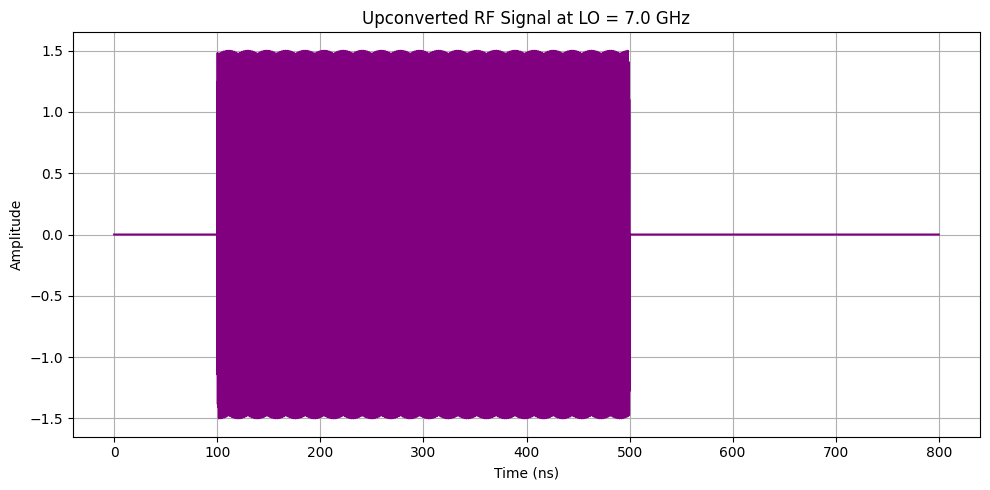

In [235]:
# RF signal must be real-valued (actual voltage)
lo_cos = np.cos(w_lo * tlist)
lo_sin = np.sin(w_lo * tlist)
RF_t = I_t * lo_cos - Q_t * lo_sin

plt.figure(figsize=(10, 5))
plt.plot(tlist/1e-9, RF_t, color='purple')
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title(f"Upconverted RF Signal at LO = {w_lo/(2*np.pi * 1e9):.1f} GHz")
plt.grid()

plt.tight_layout()
plt.show()

### Sanity check: Demodulation to retrieve original signal

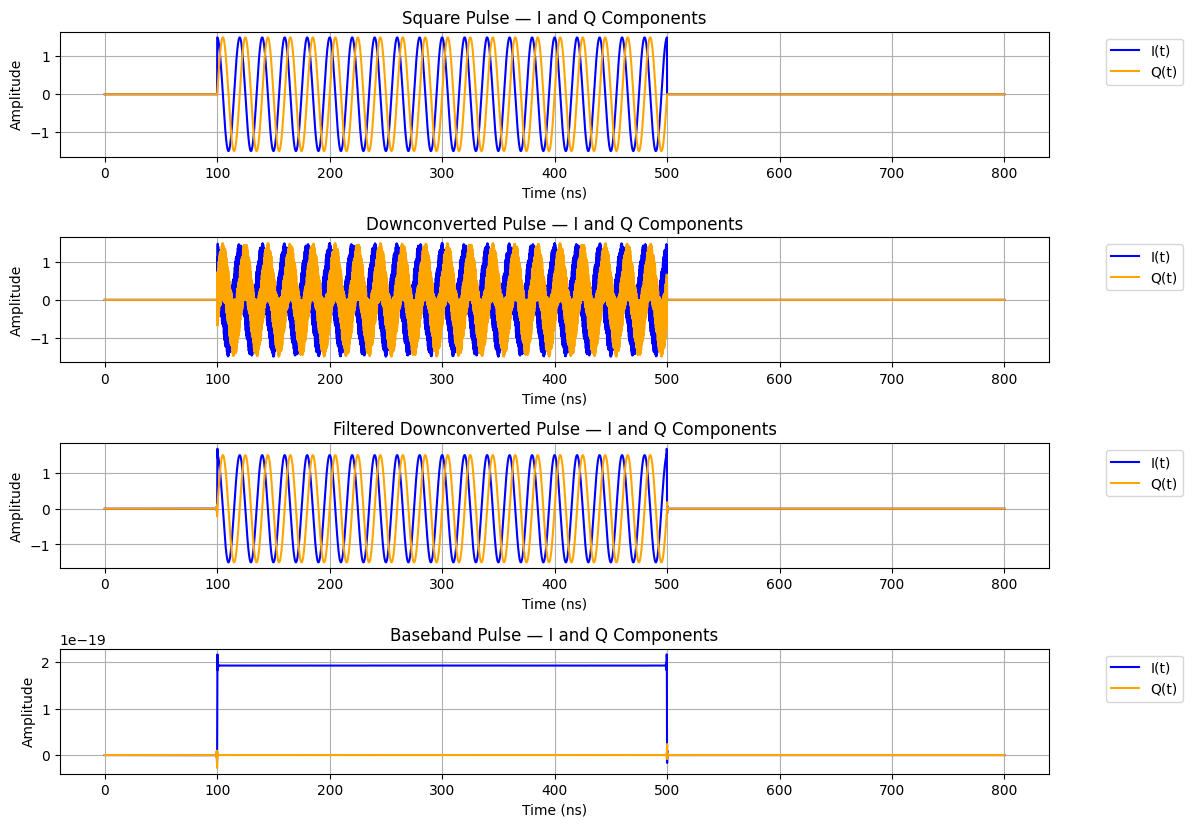

In [236]:
I_t_down = RF_t * lo_cos
Q_t_down = - RF_t * lo_sin

cutoff_frequency_lo = 2 * w_lo/(2*np.pi) # Hz
sampling_rate_lo = 5e10 # Hz
order = 4

# Calculate normalized cutoff frequency
nyquist_frequency_lo = 0.5 * sampling_rate_lo
normalized_cutoff_lo = cutoff_frequency_lo / nyquist_frequency_lo

# Design the Butterworth filter
sos_lo = butter(order, normalized_cutoff_lo, btype='low', analog=False, output='sos')
I_t_filt = 2 * sosfiltfilt(sos_lo, I_t_down) # Restore magnitude from downconversion
Q_t_filt = 2 * sosfiltfilt(sos_lo, Q_t_down)

V_t_filt = I_t_filt + 1j * Q_t_filt # Enters complex plane

V_t_base = V_t_filt * np.exp(-1j * (w_if * tlist + phi)) # Get back complex (actually just real) envelope

cutoff_frequency_if = 2 * w_if/(2*np.pi) # Hz
sampling_rate_if = 5e10 # Hz
order = 4

# Calculate normalized cutoff frequency
nyquist_frequency_if = 0.5 * sampling_rate_if
normalized_cutoff_if = cutoff_frequency_if / nyquist_frequency_if

# Design the Butterworth filter
sos_if = butter(order, normalized_cutoff_if, btype='low', analog=True, output='sos')
I_t_env = 2 * sosfiltfilt(sos_if, np.real(V_t_base)) # Restore magnitude from downconversion
Q_t_env = 2 * sosfiltfilt(sos_if, np.imag(V_t_base))

plt.figure(figsize=(12, 10))

plt.subplot(5,1,1)
plt.plot(tlist/1e-9, I_t, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t, label='Q(t)', color='orange')
plt.title("Square Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Demodulate with LO, Contains second term that is a double-LO-frequency image
plt.subplot(5,1,2)
plt.plot(tlist/1e-9, I_t_down, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t_down, label='Q(t)', color='orange')
plt.title("Downconverted Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Filtered out double-LO-frequency image, recovered original image
plt.subplot(5,1,3)
plt.plot(tlist/1e-9, I_t_filt, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t_filt, label='Q(t)', color='orange')
plt.title("Filtered Downconverted Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Demodulate with LO, removes complex componen to get real pulse
plt.subplot(5,1,4)
plt.plot(tlist/1e-9, I_t_env, label='I(t)', color='blue')
plt.plot(tlist/1e-9, Q_t_env, label='Q(t)', color='orange')
plt.title("Baseband Pulse — I and Q Components")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

### Interaction with the readout resonator (Rotating Frame)

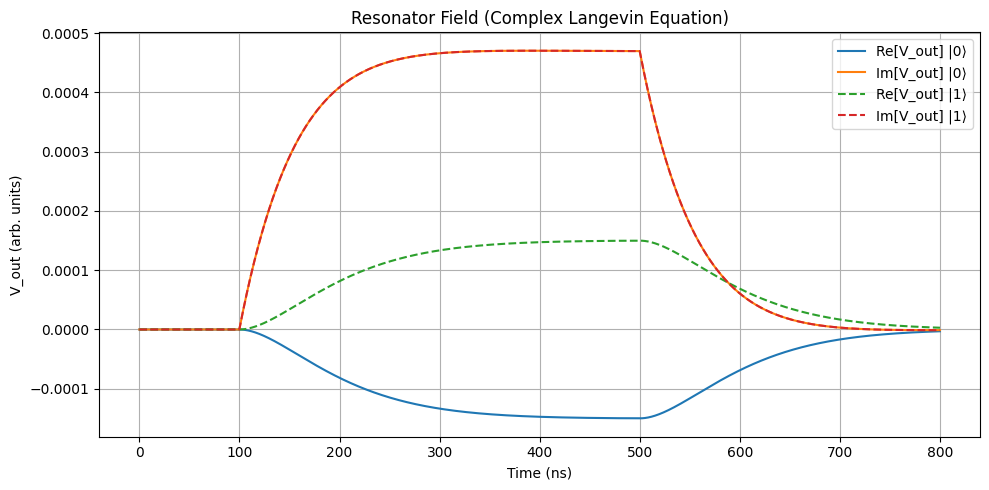

In [237]:
# Define drive
def b_in(t):
    try:
        pulse_start = 100e-9
        pulse_width = 400e-9
        amp = 1.5
        mask = (t >= pulse_start) & (t < pulse_start + pulse_width)
        envelope = amp * np.exp(1j * (0 * t + phi)) if mask else 0.0
        return envelope
    
    except Exception as e:
        print(f"b_in error at t={t}: {e}")
        return 0.0
    
# Define Heisenburg picture 
def langevin(t, a_vec, qubit_state):
    omega_eff = chi * qubit_state
    return -1j * omega_eff * a_vec - (k / 2) * a_vec +  1j * np.sqrt(k) * b_in(t)

def run_langevin(qubit_state):
    solver = ode(langevin)
    solver.set_integrator('zvode', method='bdf')  # complex-valued ODE solver
    solver.set_initial_value(0.0+0.0j, tlist[0])
    solver.set_f_params(qubit_state)

    a_vals = []

    for _ in range(len(tlist)):
        if not solver.successful():
            print("Integration failed at t =", solver.t)
            break
        solver.integrate(solver.t + dt)
        a_vals.append(solver.y)

    return np.array(a_vals)

# Run for both qubit states
a_0 = run_langevin(-1)
a_1 = run_langevin(1)

plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, np.real(a_0), label='Re[V_out] |0⟩')
plt.plot(tlist * 1e9, np.imag(a_0), label='Im[V_out] |0⟩')
plt.plot(tlist * 1e9, np.real(a_1), '--', label='Re[V_out] |1⟩')
plt.plot(tlist * 1e9, np.imag(a_1), '--', label='Im[V_out] |1⟩')
plt.xlabel("Time (ns)")
plt.ylabel("V_out (arb. units)")
plt.title("Resonator Field (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

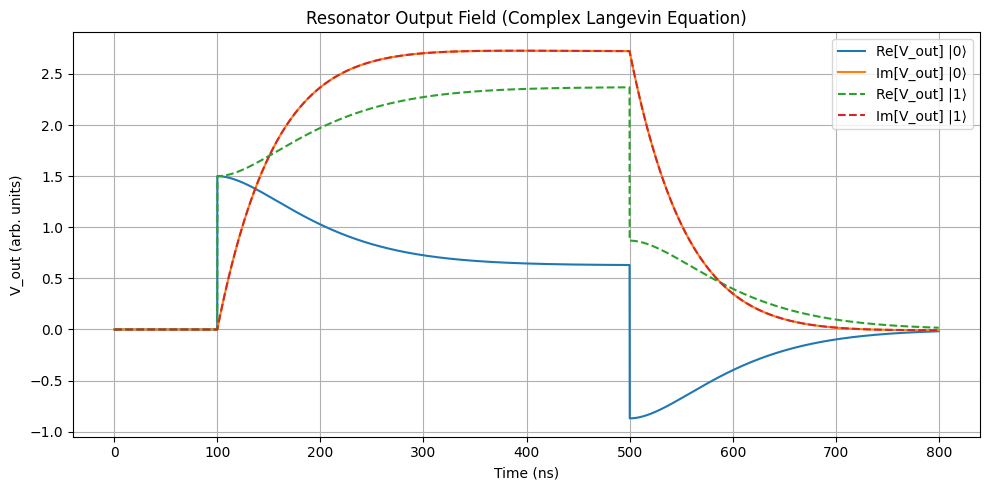

In [238]:
V_out_0 = np.sqrt(k) * a_0.flatten() + np.array([b_in(t) for t in tlist])
V_out_1 = np.sqrt(k) * a_1.flatten() + np.array([b_in(t) for t in tlist])

plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, np.real(V_out_0).flatten(), label='Re[V_out] |0⟩')
plt.plot(tlist * 1e9, np.imag(V_out_0).flatten(), label='Im[V_out] |0⟩')
plt.plot(tlist * 1e9, np.real(V_out_1).flatten(), '--', label='Re[V_out] |1⟩')
plt.plot(tlist * 1e9, np.imag(V_out_1.flatten()), '--', label='Im[V_out] |1⟩')
plt.xlabel("Time (ns)")
plt.ylabel("V_out (arb. units)")
plt.title("Resonator Output Field (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

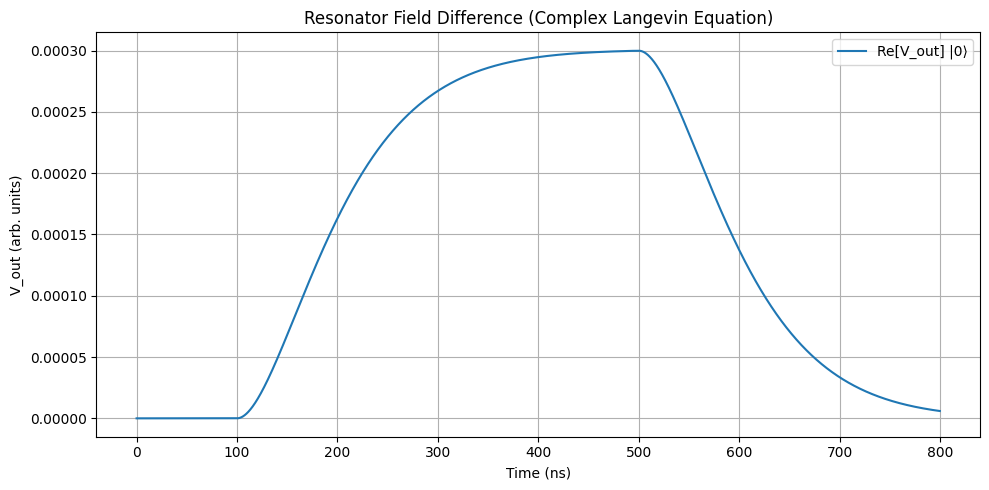

In [239]:
plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, abs(np.real(a_0)-np.real(a_1)), label='Re[V_out] |0⟩')
plt.xlabel("Time (ns)")
plt.ylabel("V_out (arb. units)")
plt.title("Resonator Field Difference (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

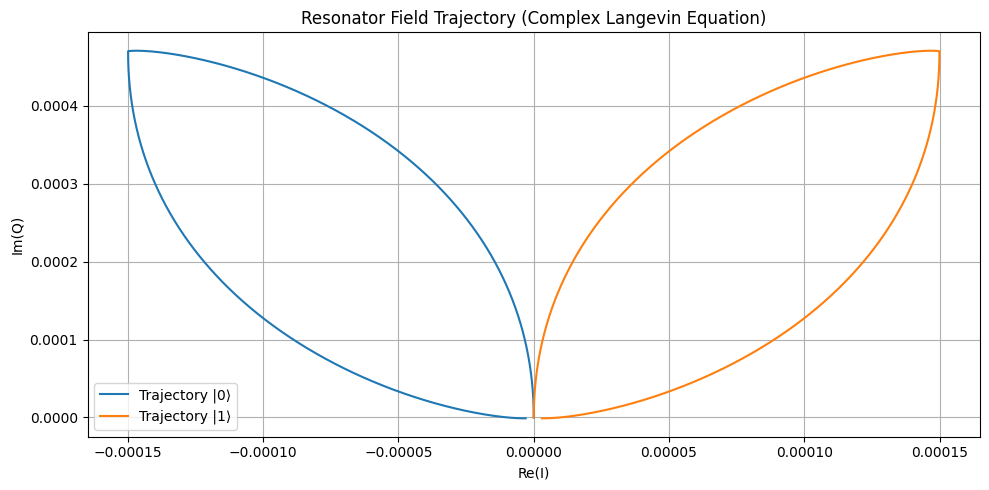

In [240]:
plt.figure(figsize=(10, 5))
plt.plot(np.real(a_0), np.imag(a_0), label='Trajectory |0⟩')
plt.plot(np.real(a_1), np.imag(a_1), label='Trajectory |1⟩')
plt.xlabel("Re(I)")
plt.ylabel("Im(Q)")
plt.title("Resonator Field Trajectory (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

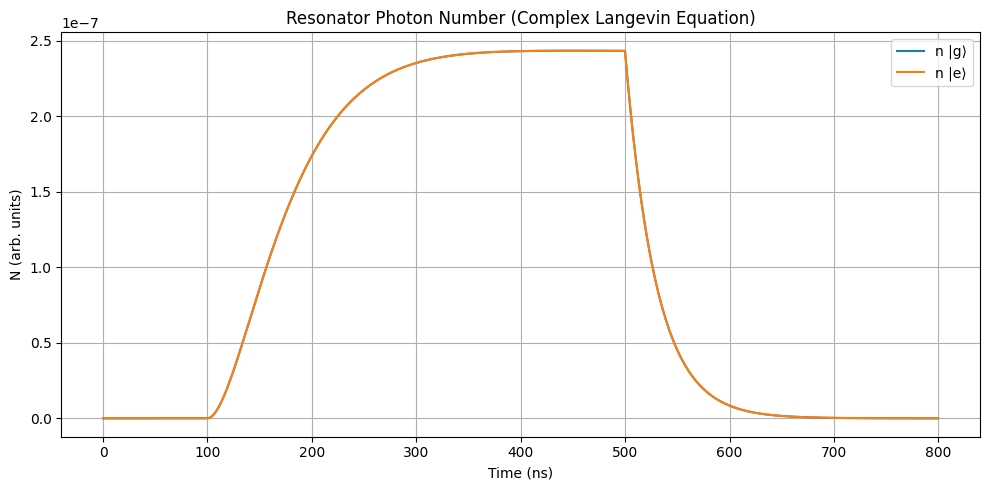

In [241]:
# Use the photon number as metric for optimising CLEAR pulse

photon_0 = np.abs(a_0)**2
photon_1 = np.abs(a_1)**2

plt.figure(figsize=(10, 5))
plt.plot(tlist * 1e9, photon_0, label='n |g⟩')
plt.plot(tlist * 1e9, photon_1, label='n |e⟩')
plt.xlabel("Time (ns)")
plt.ylabel("N (arb. units)")
plt.title("Resonator Photon Number (Complex Langevin Equation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Interaction with the readout resonator (Lab Frame)

In [242]:
def b_in(t):
    pulse_start = 100e-9
    pulse_width = 400e-9
    amp = 1.5
    if pulse_start < t < pulse_start + pulse_width:
        env = amp * np.exp(1j * (w_if * t + phi))
        return np.real(env) * np.cos(w_lo * t) - np.imag(env) * np.sin(w_lo * t)
    else:
        return 0.0

def langevin(t, a, sigma_z):
    omega_eff = wr + chi * sigma_z
    return -1j * omega_eff * a - (k / 2) * a + 1j * np.sqrt(k) * b_in(t)

def run_langevin(sigma_z):
    solver = ode(langevin)
    solver.set_integrator('zvode', method='bdf')
    solver.set_initial_value(0.0+0.0j, tlist[0])
    solver.set_f_params(sigma_z)

    a_vals = []
    for _ in range(len(tlist)):
        if not solver.successful():
            print('F')
            break
        solver.integrate(solver.t + dt)
        a_vals.append(solver.y)

    return np.array(a_vals)

# Simulate for qubit in |0⟩ and |1⟩ (σ_z = +1 and -1)
a_0 = run_langevin(-1)
a_1 = run_langevin(+1)

### RF response from the resonator: input-output theory

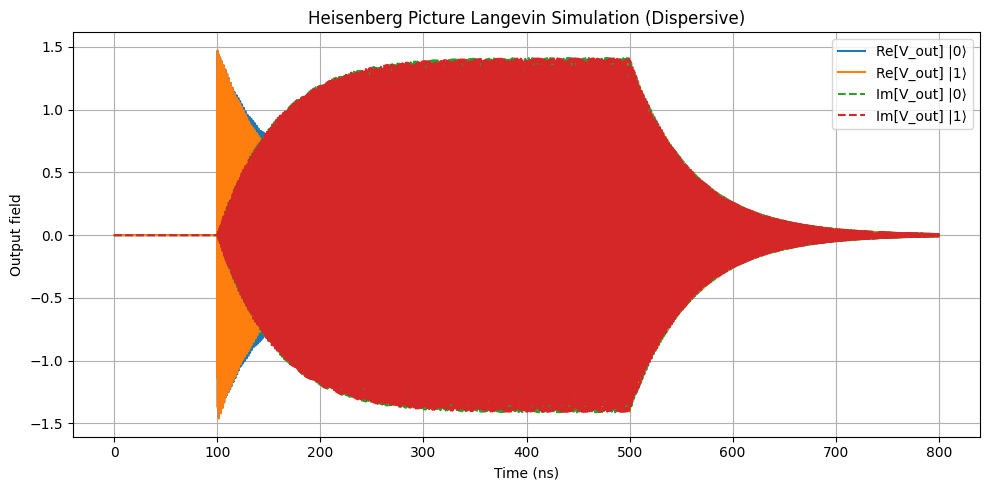

In [243]:
# Compute output field
V_out_0 = np.sqrt(k) * a_0.flatten() + np.array([b_in(t) for t in tlist.flatten()])
V_out_1 = np.sqrt(k) * a_1.flatten() + np.array([b_in(t) for t in tlist.flatten()])

# Plot
plt.figure(figsize=(10,5))
plt.plot(tlist * 1e9, np.real(V_out_0), label="Re[V_out] |0⟩")
plt.plot(tlist * 1e9, np.real(V_out_1), label="Re[V_out] |1⟩")
plt.plot(tlist * 1e9, np.imag(V_out_0), '--', label="Im[V_out] |0⟩")
plt.plot(tlist * 1e9, np.imag(V_out_1), '--', label="Im[V_out] |1⟩")
plt.xlabel("Time (ns)")
plt.ylabel("Output field")
plt.title("Heisenberg Picture Langevin Simulation (Dispersive)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Real value conversion as only real values transmitted along voltage line
V_out_1 = np.real(V_out_1)
V_out_0 = np.real(V_out_0)

### Demodulation of the RF signal

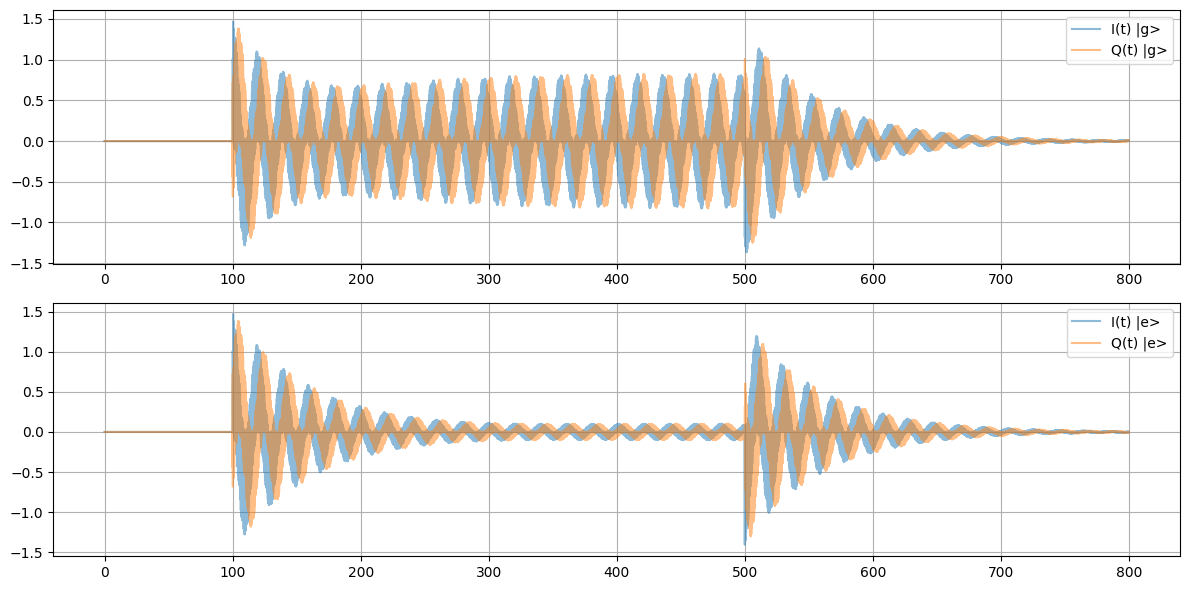

In [245]:
# Demodulation: complex demodulation
V_down_0_I = V_out_0 * np.cos(w_lo * tlist)
V_down_0_Q = - V_out_0 * np.sin(w_lo * tlist)
V_down_1_I = V_out_1 * np.cos(w_lo * tlist)
V_down_1_Q = - V_out_1 * np.sin(w_lo * tlist)

V_down_0 = V_down_0_I + 1j * V_down_0_Q
V_down_1 = V_down_1_I + 1j * V_down_1_Q

# V_down_0 = V_out_0 * np.exp(-1j * w_lo * tlist)
# V_down_1 = V_out_1 * np.exp(-1j * w_lo * tlist)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(tlist * 1e9, np.real(V_down_0), label="I(t) |g>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_down_0), label="Q(t) |g>", alpha=0.5)
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(tlist * 1e9, np.real(V_down_1), label="I(t) |e>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_down_1), label="Q(t) |e>", alpha=0.5)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

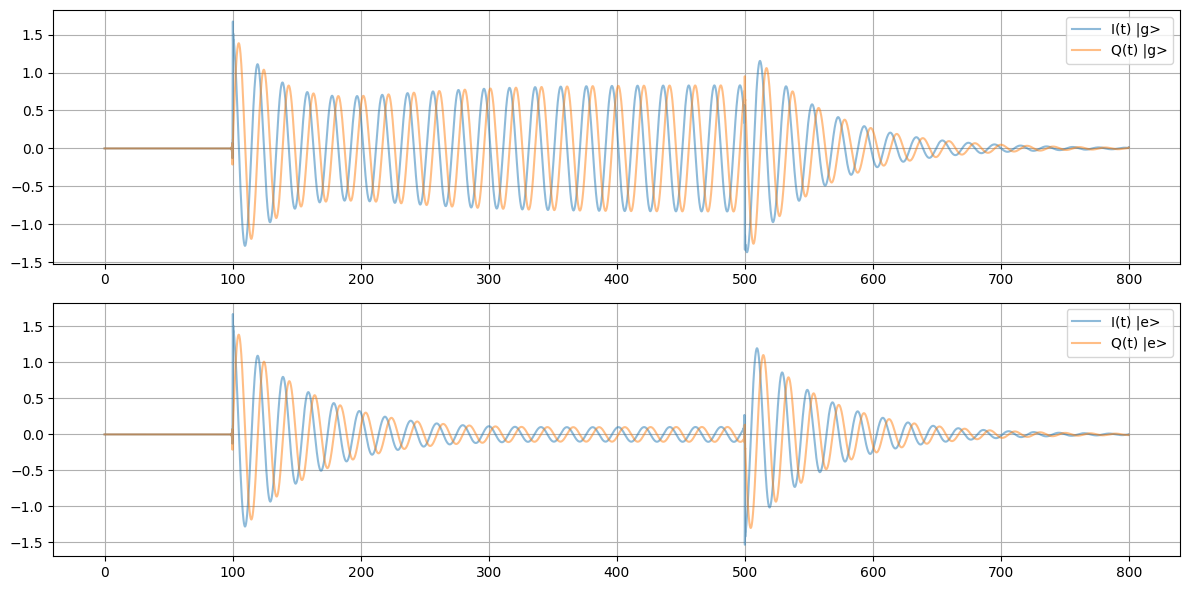

In [246]:
cutoff_frequency_if = 2 * w_lo/(2*np.pi) # Hz
sampling_rate_if = 5e10 # Hz
order = 4

# Calculate normalized cutoff frequency
nyquist_frequency_if = 0.5 * sampling_rate_if
normalized_cutoff_if = cutoff_frequency_if / nyquist_frequency_if

# Design the Butterworth filter
sos_if = butter(order, normalized_cutoff_if, btype='low', analog=False, output='sos')
V_down_0 = 2 * sosfiltfilt(sos_if, V_down_0) # Restore magnitude from downconversion
V_down_1 = 2 * sosfiltfilt(sos_if, V_down_1)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(tlist * 1e9, np.real(V_down_0), label="I(t) |g>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_down_0), label="Q(t) |g>", alpha=0.5)
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(tlist * 1e9, np.real(V_down_1), label="I(t) |e>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_down_1), label="Q(t) |e>", alpha=0.5)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


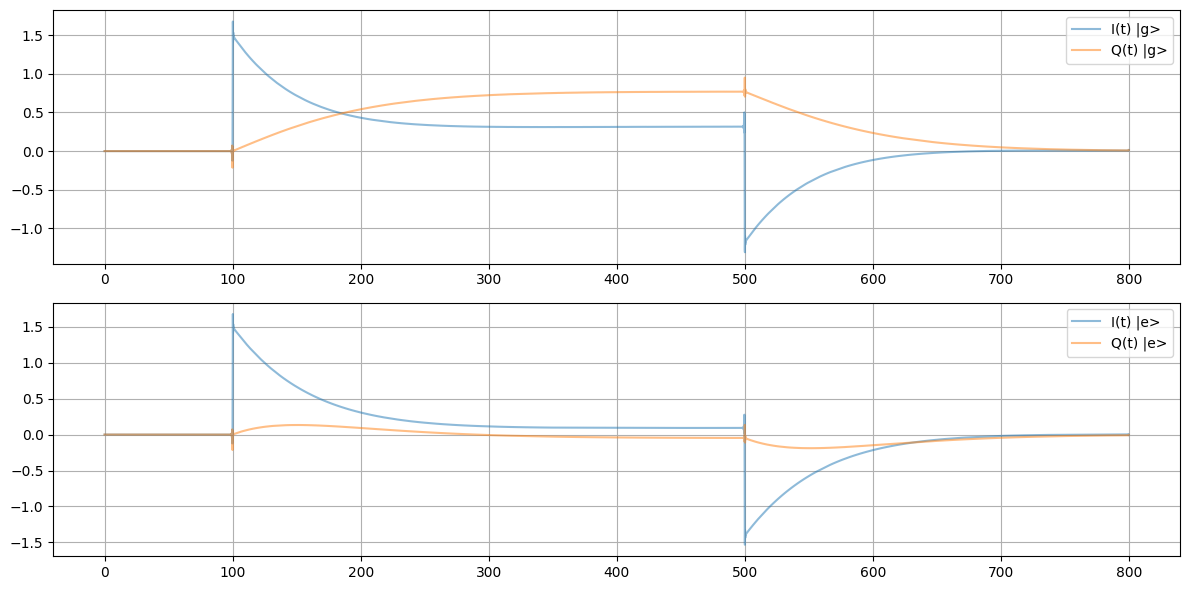

In [247]:
V_baseband_0 = V_down_0 * np.exp(-1j * w_if * tlist)
V_baseband_1 = V_down_1 * np.exp(-1j * w_if * tlist)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(tlist * 1e9, np.real(V_baseband_0), label="I(t) |g>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_baseband_0), label="Q(t) |g>", alpha=0.5)
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(tlist * 1e9, np.real(V_baseband_1), label="I(t) |e>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_baseband_1), label="Q(t) |e>", alpha=0.5)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

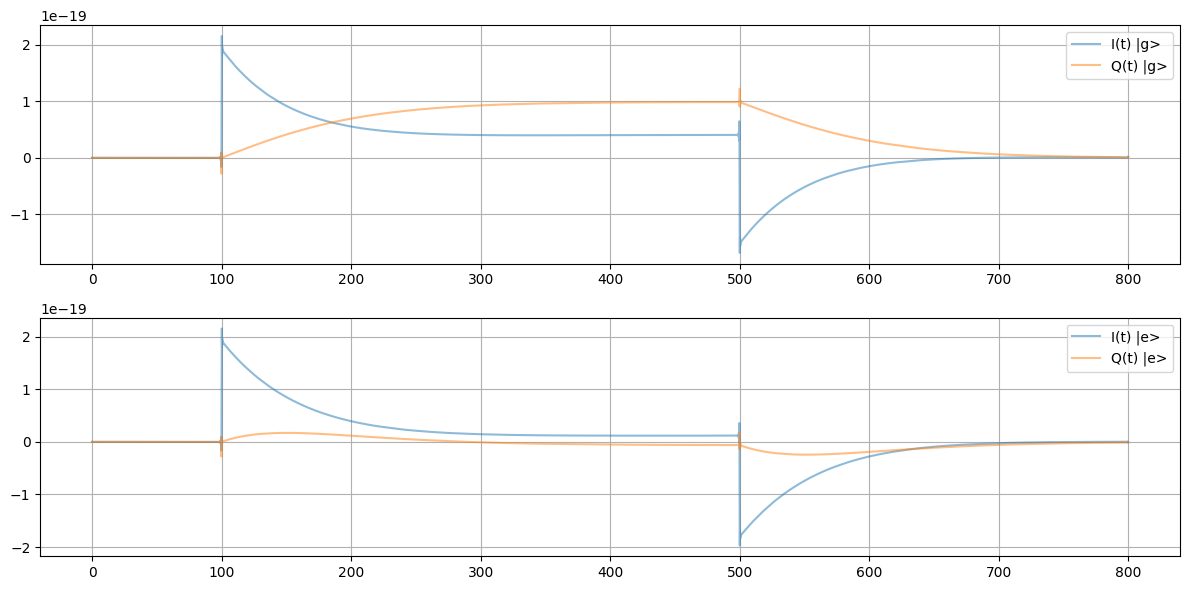

In [248]:
cutoff_frequency_if = 2 * w_if/(2*np.pi) # Hz
sampling_rate_if = 5e10 # Hz
order = 4

# Calculate normalized cutoff frequency
nyquist_frequency_if = 0.5 * sampling_rate_if
normalized_cutoff_if = cutoff_frequency_if / nyquist_frequency_if

# Design the Butterworth filter
sos_if = butter(order, normalized_cutoff_if, btype='low', analog=True, output='sos')
V_env_0 = 2 * sosfiltfilt(sos_if, V_baseband_0) # Restore magnitude from downconversion
V_env_1 = 2 * sosfiltfilt(sos_if, V_baseband_1)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(tlist * 1e9, np.real(V_env_0), label="I(t) |g>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_env_0), label="Q(t) |g>", alpha=0.5)
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(tlist * 1e9, np.real(V_env_1), label="I(t) |e>", alpha=0.5)
plt.plot(tlist * 1e9, np.imag(V_env_1), label="Q(t) |e>", alpha=0.5)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


### Integration Weights and Integration

In [249]:
pulse_start = 100e-9
pulse_width = 400e-9
steady_time = 321e-9

integration_start = pulse_start + steady_time
integration_duration = pulse_start + pulse_width
integration_mask = (tlist >= integration_start) & (tlist < integration_start + integration_duration)
integration_time = tlist[integration_mask]

# Optimal integration weights: normalised average trace envelope difference between |g⟩ and |e⟩ states
w = np.conj(V_env_1 - V_env_0)
w /= np.linalg.norm(w)  # Normalize

S_g = np.sum((V_env_0 * w)[integration_mask]) * dt
S_e = np.sum((V_env_1 * w)[integration_mask]) * dt

print(f"Demodulated signal |g> S = {S_g:} (magnitude = {np.abs(S_g):}, phase = {np.angle(S_g):.4f} rad)")
print(f"Demodulated signal |e> S = {S_e:} (magnitude = {np.abs(S_e):}, phase = {np.angle(S_e):.4f} rad)")

Demodulated signal |g> S = (-2.128120696445298e-28-1.014542761638621e-28j) (magnitude = 2.35758238749617e-28, phase = -2.6967 rad)
Demodulated signal |e> S = (7.068332820046778e-29-1.014542761638621e-28j) (magnitude = 1.236491125622349e-28, phase = -0.9623 rad)


### Plotting measurement on complex I/Q plane

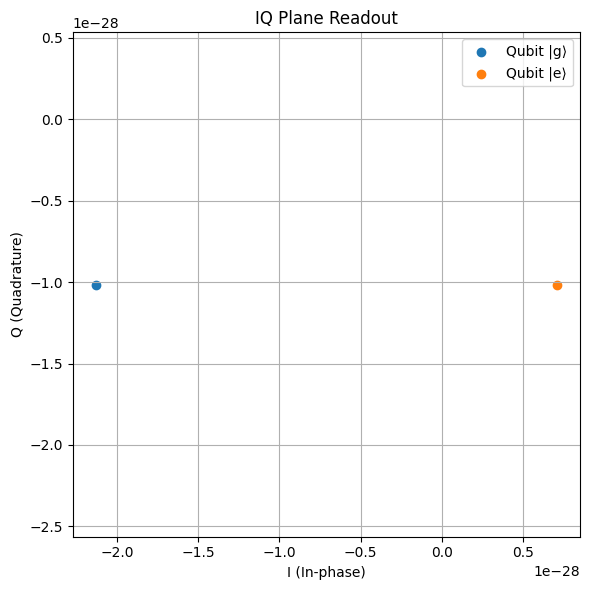

In [250]:
plt.figure(figsize=(6, 6))

plt.scatter(S_g.real, S_g.imag, label='Qubit |g⟩')
plt.scatter(S_e.real, S_e.imag, label='Qubit |e⟩')

plt.xlabel("I (In-phase)")
plt.ylabel("Q (Quadrature)")
plt.title("IQ Plane Readout")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()